# Parcellating the parcellation issue

The 2017 Neuroimage special issue on brain parcellation and segmentation features 38 papers, providing a snapshot of some of the best recent developments in what is a really vibrant area of research. Parcellation, segmentation ( and clustering, and community detection...) are just a few different names for a single general operation, that is pervasive across science. The general objective of a parcellation is to identify a limited number of categories that summarize well the characteristics observed across a large collection of examples. Sometimes, parcellation operates in the presence of true, mostly discrete entitites, such as the T1 contrast of the brain white and grey matter tissues. Sometimes, there are general patterns but the line has to be drawn more or less arbitrarily between them, just like Brodmann did in between brain areas. But in large, complex data, such as those neuroscientists are so fond of, parcellation is a vital technique to get a broad understanding of the patterns present in data while abstracting out less relevant details. So when time came to write this editorial and summarize the various contributions of these 38 papers, we could not fail to recognize yet another parcellation problem, and we responded with modern, data driven and open source tools. 

In [2]:
# Import a set of python tools, drawn from the jupyter data-science-notebooks docker stack
# https://github.com/jupyter/docker-stacks
import urllib.request
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

# Get the data
We first assembled the title, the name of the corresponding author, and the abstract for all the articles into a tabular-separated values (tsv) file, which we publicly archived on [Figshare](https://doi.org/10.6084/m9.figshare.5497468.v2). The following URL request is simply retrieving these data and loading them using pandas:

In [3]:
# Download the tsv file from the web
urllib.request.urlretrieve("https://ndownloader.figshare.com/files/9512587","YNIMG_BrainParcellation_summary.tsv")
# Read the tsv file with pandas
data = pd.read_csv('YNIMG_BrainParcellation_summary.tsv', sep='\t',header=0)
# Show us the data!
data

,Article,Author,Abstract
0,Functional atlas of the awake rat brain: a neu...,Nanyin Zhang,Connectivity-based parcellation approaches pre...
1,Automated individual-level parcellation of Bro...,Daniel S Margulies,Broca's region can be subdivided into its cons...
2,"Manual segmentation of the fornix, fimbria, an...",Robert S.C. Amaral,"Recently, much attention has been focused on t..."
3,An MRI Von Economo - Koskinas Atlas,Martijn Pieter van den Heuvel,The cerebral cortex displays substantial varia...
4,Groupwise Structural Parcellation of the Whole...,Guillermo Alejandro Gallardo Diez,Current theories hold that brain function is h...
5,Evaluation of multimodal segmentation based on...,Niels K Focke,Voxel-based morphometry is still mainly based ...
6,Topographic organization of the cerebral corte...,Simon B Eickhoff,One of the most specific but also challenging ...
7,Connectivity-based parcellation reveals distin...,Joshua Henk Balsters,Autism Spectrum Disorder (ASD) has been associ...
8,The heterogeneity of the left dorsal premotor ...,Sarah GENON,Despite the common conception of the dorsal pr...
9,DeepNAT: Deep Convolutional Neural Network for...,Christian Wachinger,"We introduce DeepNAT, a 3D Deep convolutional ..."


# Build features
For each paper, we used [scikitlearn](http://scikit-learn.org) to extract a bag of words representation for each abstract, picking on the 300 most important terms seen across all articles based on a term frequency-inverse document frequency (tf-idf) index (http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). Following that, a special value decomposition was used to further reduce the dimensionality of the abstracts to 10 components. We ended up with a data matrix `X` of dimension 38 (articles) times 10 (abstract text components).

In [4]:
# Prepare a model to extract a bag of words representation
vectorizer = TfidfVectorizer(max_df=0.5, max_features=300,
                                 min_df=2, stop_words='english',
                             use_idf=True)
X = vectorizer.fit_transform(data.Abstract) # apply the TFIDF model to the abstracts of the papers
fts = vectorizer.get_feature_names() # Get the most relevant terms selected by the procedure
svd = TruncatedSVD(10) # Prepare the SVD model
normalizer = Normalizer(copy=False) # Normalize the outputs of the svd
lsa = make_pipeline(svd, normalizer) # Put the SVD and normalization in a pipeline
X = lsa.fit_transform(X) # Apply the SVD to the TFIDF features
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 38, n_features: 10


# Parcellate the papers

Now that the content of each paper has been condensed into only 10 (hopefully informative) numbers, we can run these features into a trusted, classic parcellation algorithm: Ward's agglomerative hierarchical clustering, as implemented in the scipy library. We cut the hierarchy to extract 7 "paper parcels", and also use the hierarchy to re-order the papers, such that similar papers are close in order, as illustrated in a dendrogram representation. 

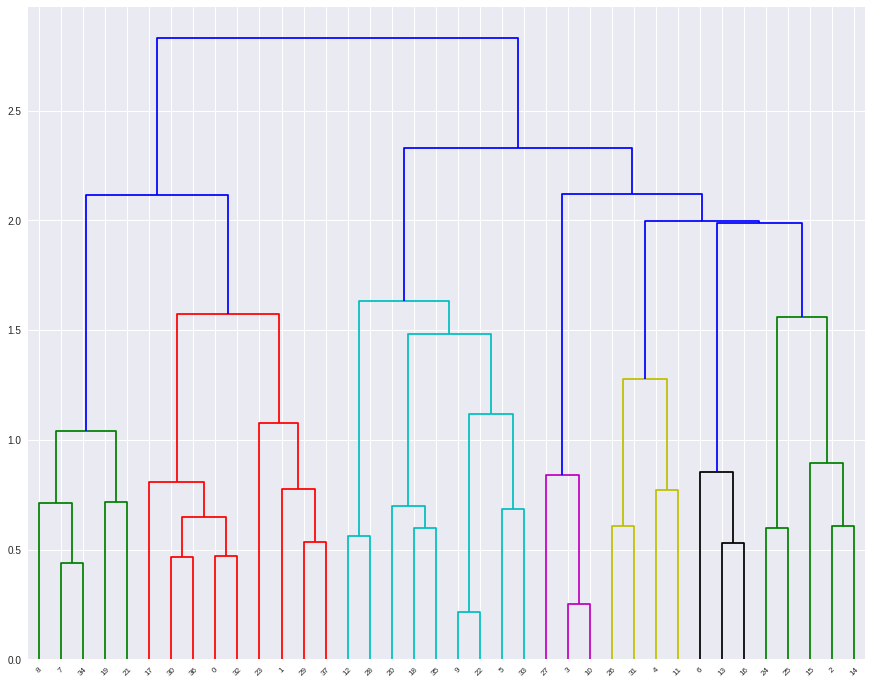

In [5]:
n_clusters = 7 # Set the number of clusters

# Make figures nice and big
fig_size = [15,12] 
plt.rcParams["figure.figsize"] = fig_size 

Xd = pd.DataFrame(X,index=range(0,data.shape[0])) # Convert the data to a pandas frame
hier = linkage(Xd, method='ward',metric='euclidean') # scipy's hierarchical clustering
res = dendrogram(hier,get_leaves=True) # Generate a dendrogram from the hierarchy
order = res.get('leaves') # Extract the order on papers from the dendrogram

# Cut the hierarchy and turn the parcellation into a dataframe
part = numpy.squeeze(cut_tree(hier,n_clusters=n_clusters))
part = pd.DataFrame(data=part[order],columns=["Parcel"],index=order)
plt.show()

# Plot the similarity matrix with the parcels

So, to get a better feel of the similarity between papers that was fed into the clustering procedure, we extracted the 38x38 (papers x papers) correlation matrix across features. Papers are re-ordered in the matrix according to the above hierarchy. Each "paper parcel" has been indicated by a black square along the diagonal, which represents the similarity measures between papers falling into the same parcel. 

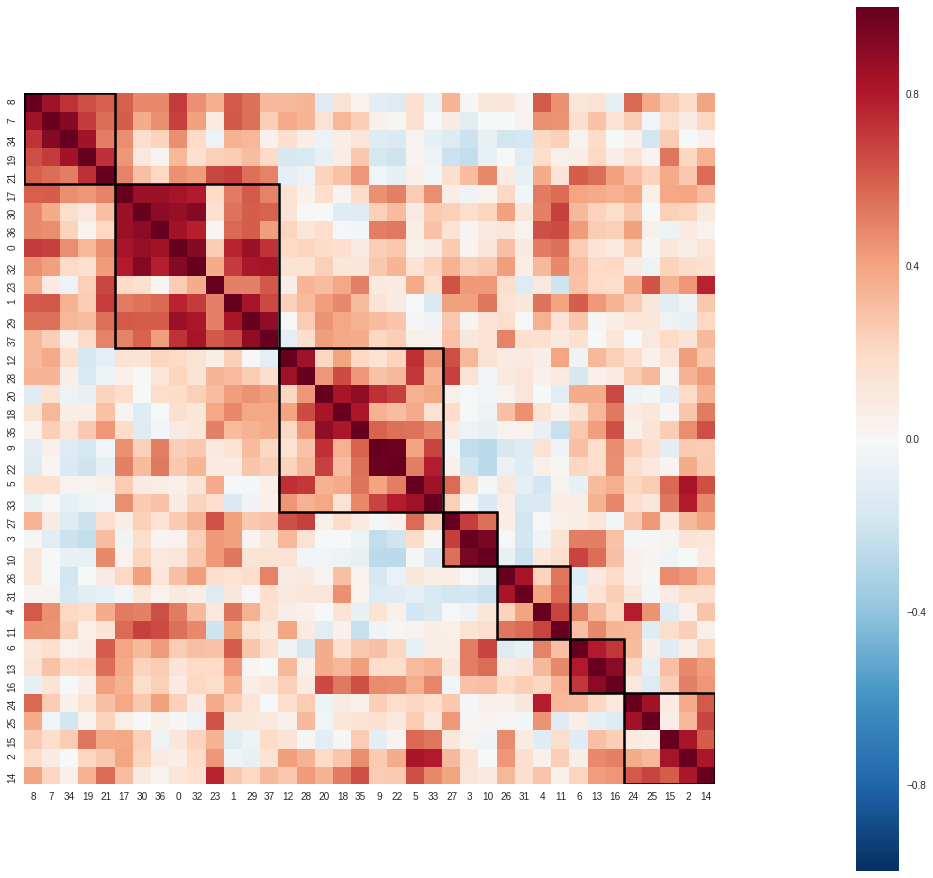

In [6]:
# Initialize figure/axes
fig = plt.figure()
plt.clf()
ax = fig.add_axes([0,0,1,1])

# Generate and reorder the correlation matrix
R = Xd.transpose().corr()
Rs = R.iloc[order,order]

# Show the matrix with seaborn
sns.heatmap(Rs, square=True )

# I somehow have not been able to find a good tool to do that
# So a bit of an ugly hack to add diagonal squares
# that highlight each cluster
val , ind = scipy.unique(part,return_index=True)
ind = scipy.sort(ind)
ind = numpy.append(ind,Rs.shape[0])
for ii in range(0,ind.shape[0]-1):
    p = matplotlib.patches.Rectangle((ind[ii] , X.shape[0]-ind[ii+1]),
                                             ind[ii+1]-ind[ii],
                                             ind[ii+1]-ind[ii],
                                             angle=0, 
                                             edgecolor='black',
                                             facecolor='none' ,
                                             linewidth=2.5)
    ax.add_patch(p)
plt.show()

# Represent the paper parcels in a table

Now, each paper of the special issue has been assigned to one and only one out of 7 possible "paper parcel". Let's list the papers together with their parcels:

In [7]:
tab = data.iloc[order] # re-order the papers using the hierarchical clustering
tab = tab.ix[:,0:2] # keep only the article title and authors 
tab = pd.concat([part,tab],axis=1, join_axes=[tab.index]) # Merge with the parcel numbers
tab.style # display the table

# Show the dominant features (words) for each parcel

For each paper parcel, we can evaluate which words contribute more to the dominant component associated with that parcel.

In [8]:
# Compute the average / std across all components
gavg = Xd.transpose()
gavg_mean = gavg.mean(axis=1)
gavg_std = gavg.std(axis=1)

# Initialize a frame to store the dominant words for each parcel
all_comp = []
words = pd.DataFrame(columns=["Parcel","word","weight"])
nb_words = 0

for cc in range(0,n_clusters): # Loop over parcels
    avg = Xd[part.Parcel==cc] # average components inside the parcel
    
    # Normalize from the grand average
    avg = avg.transpose()
    avg = avg.mean(axis=1)
    avg = numpy.divide((avg-gavg_mean),gavg_std)
    
    # Look for the component with hightest contribution
    # There could in theory be components with negative contributions as well
    # In practice here this never happens
    val_avg , ind_avg = numpy.unique(-  avg ,return_index=True)
    val , ind = numpy.unique(- svd.components_[ind_avg[0]],return_index=True) # Rank the components
    ind = ind[0:6] # Just retain the first 6 words
    for ww in ind: # Add the words and associated parcels / weights to the table
        nline = pd.DataFrame([[cc,fts[ww],numpy.round(100*svd.components_[ind_avg[0]][ww])]],
                            columns=["Parcel","word","weight"],
                            index=[nb_words])
        words = pd.DataFrame.append(words,nline)
        nb_words = nb_words+1
words

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


,Parcel,word,weight
0,0.0,functional,27.0
1,0.0,connectivity,22.0
2,0.0,parcellation,20.0
3,0.0,segmentation,19.0
4,0.0,network,16.0
5,0.0,atlas,14.0
6,1.0,nuclei,33.0
7,1.0,motor,32.0
8,1.0,disorders,19.0
9,1.0,template,18.0


So, by checking the words and the title, the paper parcels are pretty clear:
  * Paper parcel 0 is composed on papers dealing with functional (resting-state) parcellations.
  * Paper parcel 1 has several papers looking at segmenting brain nuclei.
  * Paper parcel 2 has papers looking at cytoarchitectonics parcels.
  * Paper parcel 3 includes papers dealing with structural (diffusion) parcellation. 
  * Paper parcel 4 includes comparison of methods for structural MRI segmentation. 
  * Paper parcel 5 is the less interpretable, with a review on brain parcellation mixed with a new software for quality control and a comparison of manual segmentation protocols.
  * Paper parcel 6 includes a series of work that investigated the parcellation of, or within, a particular brain area, using mostly brain connectivity. 